In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!nvidia-smi

Mon Jan 17 14:25:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Utils

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as img
import pandas as pd
import os
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.layers as L
import math
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub

os.chdir('/content/drive/MyDrive/Colab Notebooks')
print(os.getcwd())
save_dir = os.path.join(os.getcwd(), 'checkpoints')
print(save_dir)
title='vgg16'
model_name = '{title}-e{epoch:04d}-loss{loss:.3f}-acc{acc:.3f}-valloss{val_loss:.3f}-valacc{val_acc:.3f}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

/content/drive/MyDrive/Colab Notebooks
/content/drive/MyDrive/Colab Notebooks/checkpoints


# Callbacks

In [5]:
# Schedule Lr
def step_decay(epoch):
   initial_lrate = 0.01
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate


def schedule(epoch):
  lr = 0.02
  if epoch<15:
    lr = 1e-2
  elif epoch<30:
    lr = 1e-3
  else:
    lr = 1e-4
schedule_lr = LearningRateScheduler(schedule(0))

In [6]:
# Reduce Lr
reduce_lr = ReduceLROnPlateau( 
    monitor="val_acc",
    factor=0.01,
    patience=3)

In [7]:
# Save model metrics
os.chdir('/content/drive/MyDrive/Colab Notebooks')
print(os.getcwd())
save_dir = os.path.join(os.getcwd(), 'checkpoints')
print(save_dir)
model_name = 'robust2-e{epoch:04d}-loss{loss:.3f}-acc{acc:.3f}-valloss{val_loss:.3f}-valacc{val_acc:.3f}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

/content/drive/MyDrive/Colab Notebooks
/content/drive/MyDrive/Colab Notebooks/checkpoints


In [8]:
callbacks = [schedule_lr,reduce_lr,checkpoint]

# Image Preprocessing 1

In [9]:
train_data_path = "/content/drive/MyDrive/Data/train_images/train_images"

train_labels = pd.read_csv("/content/drive/MyDrive/Data/labels_train.csv")
labels= train_labels['class_id']
cat_labels = []
for l in labels:
  if l==0:
    cat_labels.append("Normal")
  elif l==1:
    cat_labels.append("Bacterial")
  else:
    cat_labels.append("Viral")


traindf = pd.DataFrame({"path":os.listdir(train_data_path),"label":cat_labels})
traindf

,path,label
0,img_7514708478869136769.jpg,Bacterial
1,img_7515586532527258581.jpg,Viral
2,img_7515769025239905494.jpg,Viral
3,img_7515441828745677211.jpg,Bacterial
4,img_7517441080549510515.jpg,Viral
...,...,...
4667,img_2255916936271551920.jpg,Viral
4668,img_225908045069656850.jpg,Bacterial
4669,img_2261332259809434389.jpg,Bacterial
4670,img_2262393463992805826.jpg,Bacterial


In [21]:
train_datagen = ImageDataGenerator(
    brightness_range = (0.2, 1), 
    zoom_range = 0.2,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    rescale = 1./255
)

train, val = train_test_split(
    traindf,
    test_size=0.35,
    random_state=1,
    shuffle=True
)

train_generator = train_datagen.flow_from_dataframe(
    train,
    directory=train_data_path,
    x_col="path",
    y_col="label",
    target_size=(224,224),
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_generator = train_datagen.flow_from_dataframe(
    val,
    directory=train_data_path,
    x_col="path",
    y_col="label",
    target_size=(224,224),
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42
)

Found 3036 validated image filenames belonging to 3 classes.
Found 1636 validated image filenames belonging to 3 classes.


In [13]:
test_img_path = "/content/drive/MyDrive/Data/test_images/test_images"

testdf = pd.DataFrame({"path":os.listdir(test_img_path)})
testdf
test_datagen = ImageDataGenerator(
    rescale=1./255,
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=testdf,
    directory=test_img_path,
    x_col='path',
    class_mode='raw',
    target_size=(224, 224),
    shuffle=False
)



KeyError: ignored

# Properties

In [13]:
EPOCHS = 25
input_shape = (224,224,3)


# Jam

In [ ]:
x_in = L.Input((input_shape))
x = L.Conv2D(filters=32,kernel_size=11,activation='relu',padding='same')(x_in)
x = L.Conv2D(filters=32,kernel_size=11,activation='relu',padding='same')(x)
x = L.BatchNormalization()(x)
x = L.MaxPool2D()(x)
x = L.Dropout(0.2)(x)

x = L.Conv2D(filters=64,kernel_size=6,activation='relu',padding='same')(x)
x = L.Conv2D(filters=64,kernel_size=6,activation='relu',padding='same')(x)
x = L.BatchNormalization()(x)
x = L.MaxPool2D()(x)
x = L.Dropout(0.3)(x)

x = L.Conv2D(filters=512,kernel_size=(3,3),activation='relu')(x)
x = L.BatchNormalization()(x)
x = L.Dropout(0.15)(x)

x = L.Conv2D(filters=256,kernel_size=(3,3),activation='relu')(x)
x = L.Conv2D(filters=128,kernel_size=3,activation='relu')(x)
x = L.BatchNormalization()(x)
x = L.MaxPool2D()(x)

x = L.Flatten()(x)
x = L.Dense(units=224,activation='relu')(x)
out = L.Dense(units=3,activation='softmax')(x)
model = Model(inputs=x_in,outputs=out)
model.compile(
      optimizer = Adam(0.02),
      loss = 'categorical_crossentropy',
      metrics=['acc']
)
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_105 (Conv2D)         (None, 224, 224, 32)      11648     
                                                                 
 conv2d_106 (Conv2D)         (None, 224, 224, 32)      123936    
                                                                 
 batch_normalization_42 (Bat  (None, 224, 224, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                                 
 dropout_46 (Dropout)        (None, 112, 112, 32)      0  

In [ ]:
  history = model.fit(
      x=train_generator,
      validation_data=valid_generator,
      steps_per_epoch =valid_generator.n//train_generator.batch_size,
      epochs=EPOCHS,
      verbose=1,
      )

Epoch 1/25
43/43 [==============================] - 84s 2s/step - loss: 161.3555 - acc: 0.4055 - val_loss: 6619.4067 - val_acc: 0.2639
Epoch 2/25
43/43 [==============================] - 66s 2s/step - loss: 1.2448 - acc: 0.4797 - val_loss: 175.7689 - val_acc: 0.3738
Epoch 3/25
43/43 [==============================] - 66s 2s/step - loss: 1.1174 - acc: 0.4746 - val_loss: 3.5095 - val_acc: 0.4608
Epoch 4/25
43/43 [==============================] - 67s 2s/step - loss: 1.0720 - acc: 0.4911 - val_loss: 1.4279 - val_acc: 0.4608
Epoch 5/25
43/43 [==============================] - 66s 2s/step - loss: 1.1259 - acc: 0.4935 - val_loss: 1.9338 - val_acc: 0.4715
Epoch 6/25
43/43 [==============================] - 65s 2s/step - loss: 1.0721 - acc: 0.4756 - val_loss: 1.0612 - val_acc: 0.4786
Epoch 7/25
43/43 [==============================] - 66s 2s/step - loss: 1.1820 - acc: 0.4673 - val_loss: 1.2697 - val_acc: 0.4765
Epoch 8/25
43/43 [==============================] - 65s 2s/step - loss: 1.0788 - ac

# Robust Model


In [17]:

 # Robust Image Sentiment Analysis Using
            #  Progressively Trained and Domain Transferred Deep Networks
            # https://arxiv.org/abs/1509.06041
            # Source Code:
            # https://github.com/Wyverson/OutdoorSent
print('Robust selected')
input_tensor = L.Input(shape=(input_shape))

model = L.Conv2D(filters=224,
                         kernel_size=(11,11),
                         strides=4,
                         activation='relu')(input_tensor)
model = L.Lambda(lambda a: tf.nn.lrn(input=a))(model)
model = L.MaxPooling2D(pool_size=(6, 6), strides=2)(model)

model = L.Conv2D(filters=256,
                         kernel_size=(5, 5),
                         strides=2,
                         activation='relu')(model)
model = L.Lambda(lambda a: tf.nn.lrn(input=a))(model)
model = L.MaxPooling2D(pool_size=(3, 3), strides=6)(model)

model = L.Flatten()(model)
model = L.Dense(units=1024, activation='relu')(model)
model = L.Dropout(rate=0.2)(model)
model = L.Dense(units=1024, activation='relu')(model)
model = L.Dropout(rate=0.2)(model)
model = L.Dense(units=24, activation='relu')(model)

predictions = L.Dense(units=3, activation='softmax')(model)
            
model = Model(inputs=[input_tensor], outputs=predictions)
model.compile(
      optimizer=Adam(step_decay(0)),
      loss="categorical_crossentropy",
      metrics=['acc']
  )
model.summary()

Robust selected
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 54, 54, 224)       81536     
                                                                 
 lambda (Lambda)             (None, 54, 54, 224)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 224)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 256)       1433856   
                                                                 
 lambda_1 (Lambda)           (None, 11, 11, 256)       0         
                                             

In [ ]:
  history = model.fit(
      x=train_generator,
      validation_data=valid_generator,
      steps_per_epoch =valid_generator.n//train_generator.batch_size,
      epochs=50,
      verbose=1,
      )

Epoch 1/50
51/51 [==============================] - 1719s 34s/step - loss: 1.3087 - acc: 0.4736 - val_loss: 1.0608 - val_acc: 0.4700
Epoch 2/50
51/51 [==============================] - 448s 9s/step - loss: 1.0583 - acc: 0.4730 - val_loss: 1.0587 - val_acc: 0.4700
Epoch 3/50
51/51 [==============================] - 258s 5s/step - loss: 1.0479 - acc: 0.4896 - val_loss: 1.0593 - val_acc: 0.4700
Epoch 4/50
51/51 [==============================] - 180s 4s/step - loss: 1.0435 - acc: 0.4963 - val_loss: 1.0609 - val_acc: 0.4700
Epoch 5/50
51/51 [==============================] - 117s 2s/step - loss: 1.0505 - acc: 0.4853 - val_loss: 1.0590 - val_acc: 0.4700
Epoch 6/50
51/51 [==============================] - 105s 2s/step - loss: 1.0558 - acc: 0.4767 - val_loss: 1.0594 - val_acc: 0.4700
Epoch 7/50
51/51 [==============================] - 133s 3s/step - loss: 1.0579 - acc: 0.4730 - val_loss: 1.0587 - val_acc: 0.4700
Epoch 8/50
51/51 [==============================] - 92s 2s/step - loss: 1.0523 - 

# VGG16

In [22]:
x_in = L.Input((input_shape))
base = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)(x_in)
x = L.GlobalAveragePooling2D()(base)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.4) (x)
out = L.Dense(3,activation='softmax')(x)
model = Model(inputs=x,outputs=out)
model.compile(
    optimizer=tf.keras.optimizers.SGD(schedule_lr),
    loss="categorical_crossentropy",
    metrics=['acc']
  )
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 512)]             0         
                                                                 
 dense_17 (Dense)            (None, 3)                 1539      
                                                                 
Total params: 1,539
Trainable params: 1,539
Non-trainable params: 0
_________________________________________________________________


In [23]:
  history = model.fit(
      x=train_generator,
      validation_data=valid_generator,
      steps_per_epoch =valid_generator.n//train_generator.batch_size,
      epochs=50,
      verbose=1,
      )

Epoch 1/50


ValueError: ignored

# ResNet

In [24]:
x_in = L.Input((input_shape))
x = tf.keras.applications.ResNet50(
    weights="imagenet",
    include_top=False,
    pooling='avg')(x_in)
x = L.Dense(units=256,activation='relu')(x)
x = L.Dropout(0.2)(x)
x = L.Dense(units=256,activation='relu')(x)
out = L.Dense(units=3,activation='softmax')(x)
model = Model(inputs=x_in,outputs=out)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.02),
    loss='categorical_crossentropy',
    metrics=['acc']
)
model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_18 (Dense)            (None, 256)               524544    
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_19 (Dense)            (None, 256)               65792     
                                                                 
 dense_20 (Dense)            (None, 3)                 771       
                                                            

In [25]:
history = model.fit(
    x=train_generator,
      validation_data=valid_generator,
      steps_per_epoch =valid_generator.n//train_generator.batch_size,
      epochs=EPOCHS,
      verbose=1
)

Epoch 1/25
51/51 [==============================] - ETA: 0s - loss: 2.3430 - acc: 0.4626

KeyboardInterrupt: ignored

# Custom Model

In [ ]:
def conv(model,filters):
  model = L.SeparableConv2D(filters=filters,kernel_size=3, activation='relu',padding='same')(model)
  model = L.BatchNormalization()(model)
  model = L.MaxPool2D()(model)
  return model


def dense(model,units,rate):
  model = L.Dense(units=units, activation='relu')(model)
  model = L.BatchNormalization()(model)
  model = L.Dropout(rate)(model)
  return model




def custom_cnn(input_shape):
  x_in = L.Input(input_shape)
  x = L.Conv2D(filters=16, kernel_size=3, padding='same')(x_in)
  x = L.Conv2D(filters=16, kernel_size=3, padding='same')(x)
  x = L.MaxPool2D()(x)
  x = conv(x,32)
  x - L.Dropout(0.25)(x)
  x = conv(x,64)
  x = conv(x,128)
  x = conv(x,256)
  x - L.Dropout(0.7)(x)
  x = L.Flatten()(x)
  x = dense(x,512,0.7)
  x = dense(x,128,0.5)
  x = dense(x,64,0.3)
  out = L.Dense(3,activation='softmax')(x)
  model = Model(inputs=x_in, outputs=out)
  model.compile(
      optimizer="adam",
      loss="binary_crossentropy",
      metrics=['acc']
  )
  model.summary()

In [ ]:
  history = model.fit(
      x=train_generator,
      validation_data=valid_generator,
      steps_per_epoch =valid_generator.n//train_generator.batch_size,
      epochs=50,
      verbose=1,
      )

# Mobile Net

In [ ]:
aaadef mobileLearning(input_shape):
  model = tf.keras.Sequential([
        hub.KerasLayer('https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/classification/5',input_shape=input_shape,trainable=False),
        L.Dense(3,"softmax")
  ])
  model.summary()
  model.compile(
      optimizer="adam",
      loss="categorical_crossentropy",
      metrics=['acc']
  )
  return model

# Plots

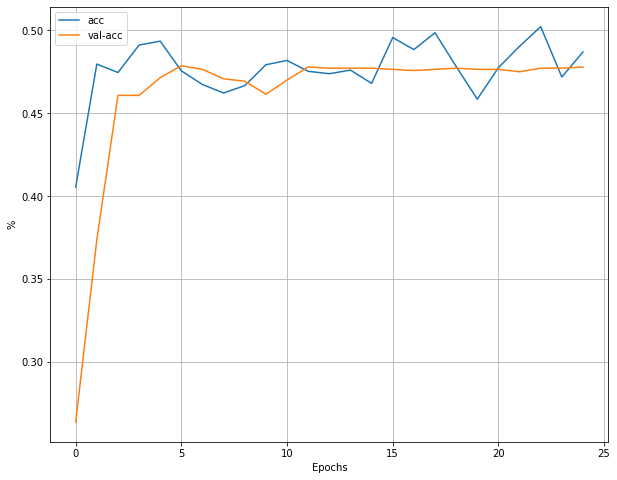

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel('Epochs')
plt.ylabel('%')
plt.legend(('acc','val-acc'))
plt.grid(b=True)

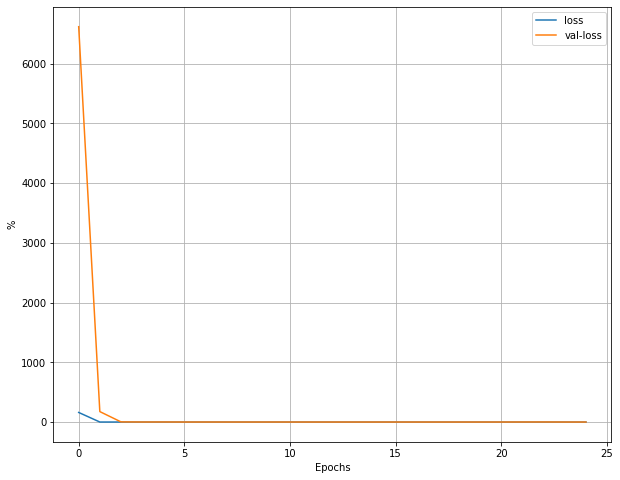

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('%')
plt.legend(('loss','val-loss'))
plt.grid(b=True)

# Evaluate and Predict

In [ ]:
scores = model.evaluate(test_generator,verbose=1)
print(f"Test Accuracy:{scores[0]}")

img = tf.keras.preprocessing.image.load_img(test[10],grayscale=False,color_mode='rgb',target_size=(224,224),interpolation='nearest')
img_arr = tf.keras.preprocessing.image.img_to_array(img)
img_arr = np.array([img_arr])  
img_arr = img_arr.astype('float32') / 255.0
img_arr.shape


predictions = model.predict(test_generator)
results = []
for i,p in enumerate(predictions):
  # print(p[])
  # print(np.argmax(p))
  head_tail = os.path.split(testdf[i]['path'])
  print(head_tail[1])
#   dic = [head_tail[1],np.argmax(p)]
#   results.append(dic)
#   if i % 250==0:
#     print(f"> Prediction for file:'{test_img_list[i]}' is Class:'{np.argmax(p)}")

# results

array([[0.49726617, 0.26260924, 0.24012452],
       [0.49726617, 0.26260924, 0.24012452],
       [0.49726617, 0.26260924, 0.24012452],
       ...,
       [0.49726617, 0.26260924, 0.24012452],
       [0.49726617, 0.26260924, 0.24012452],
       [0.49726617, 0.26260924, 0.24012452]], dtype=float32)

# Save Model

In [ ]:
model.save(f"/content/drive/MyDrive/Colab Notebooks/saved_models")

# Save results in csv

In [ ]:
import csv
with open('/content/drive/MyDrive/Colab Notebooks/vgg16-1.csv', 'w') as csvfile:
  write = csv.writer(csvfile)
  write.writerow(headers)
  write.writerows(results)